In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

# Loading the Data

In [2]:
hdul=fits.open('advact_tt_patch.fits')
map = hdul[0].data
map = np.asarray(map, dtype = 'float')
hdul.close()

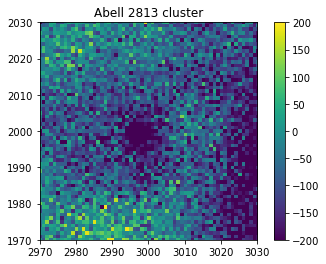

In [3]:
plt.imshow(map, vmin = -200.0, vmax = 200)
plt.xlim(2970, 3030)
plt.ylim(1970, 2030)
plt.colorbar()
plt.title('Abell 2813 cluster')
plt.show()

# Defining Functions

In [4]:
def mygauss(pars, width):
    vec = np.asarray(np.arange(-width, width), dtype = 'float')
    amp = pars[0]
    dx = pars[1]
    dy = pars[2]
    sigma = pars[3]

    xvec = vec - dx
    yvec = vec - dy
    xmat = np.outer(xvec, np.ones(len(xvec)))
    ymat = np.outer(np.ones(len(yvec)), yvec)
    rmat = xmat**2 + ymat**2
    model = np.exp(-0.5 * (rmat/sigma**2)) * amp

    return model

def get_model_derivs(fun, pars, dpar, width):
    model = fun(pars, width)
    npar = len(pars)
    derivs = [None] * npar
    
    for i in range(npar):
        pp = pars.copy()
        pp[i] = pars[i] + dpar[i]
        m_plus = fun(pp, width)
        pp[i] = pars[i] - dpar[i]
        m_minus = fun(pp, width)
        derivs[i] = (m_plus - m_minus)/(2 * dpar[i])
    
    return model, derivs

def get_model_derivs_ravel(fun, pars, dpar, width):
    model, derivs = get_model_derivs(fun, pars, dpar, width)
    model = np.ravel(model)
    npar = len(pars)
    derivs_out = np.empty([len(model), len(pars)])
    
    for i in range(npar):
        derivs_out[:,i] = np.ravel(derivs[i])
    
    return model, derivs_out

def newton(pars, data, Ninv, fun, width, dpar, niter = 10):
    
    for i in range(niter):
        model, derivs = get_model_derivs_ravel(fun, pars, dpar, width)
        resid = data - model
        lhs = derivs.T@Ninv@derivs
        rhs = derivs.T@Ninv@resid
        shift = np.linalg.inv(lhs)@rhs
        #print('Parameter Shifts = ', shift)
        pars = pars + shift
    
    return pars

# Fitting with Newton's Method

In [5]:
x0 = 2997
y0 = 1998
width = 30
patch = map[x0-width:x0+width, y0-width:y0+width]
pars = np.asarray([-200,0,0,1], dtype = 'float')
dpar = np.asarray([1.0,0.01,0.01,0.01,1])/10
Ninv = np.eye(len(patch)**2)

fitp = newton(pars, np.ravel(patch), Ninv, mygauss, width, dpar, niter = 10)
fit_model=mygauss(fitp,width)

print('Best-Fit amplitude is ',fitp[0])
print('Best-Fit sigma is ',fitp[3])
print('Best-Fit positions are ',fitp[1], fitp[2])

Best-Fit amplitude is  154.35519596041942
Best-Fit sigma is  13.604295489900784
Best-Fit positions are  10.740635508068893 -0.5751627610810801


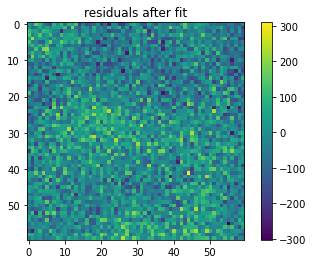

In [6]:
residuals = patch - fit_model
plt.imshow(residuals)
plt.colorbar()
plt.title('residuals after fit')
plt.show()